# Lagrangian Neural Networks (LNNs)

*This notebook borrows heavily from the original [LNN tutorial](https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq) provided by the authors of the [LNN paper](https://arxiv.org/abs/2003.04630).*

The Lagrangian dynamics is a reformulation of the Newtonian dynamics using the Lagrangian function defined as:

$$L(q,\dot q, t)\equiv T(q,\dot q, t)-V(q,\dot q, t),$$

where $T$ is the kinetic energy of the system, $V$ is its potential energy, $q=(q_1, q_2,\ldots, q_n)$ is a set of generalized coordinates describing the system and $\dot q\equiv\frac{dq}{dt}$. Given a Lagrangian, the dynamics of the system is defined by the Euler-Lagrange (E-L) equations:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot q}=\frac{\partial L}{\partial q}.$$

As derived in the lecture material, it follows from the E-L equations that the accelerateion $\ddot q$ is:

$$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^\top L)^{-1}\left[\nabla_q L - (\nabla_{\dot q}\nabla_q^\top L)\dot q\right].$$

This allows us to predict the evolution of the given system by integrating this equation numerically:

$$\frac{d}{dt}
\begin{pmatrix}
q \\
\dot q
\end{pmatrix}
=
\begin{pmatrix}
\dot q \\
\ddot q
\end{pmatrix}.$$

## The double pendulum problem

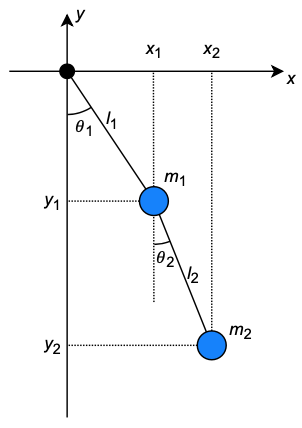

In this notebook, we'll try to solve the double pendulum problem, as shown in the figure above. The system is formed by attaching one pendulum directly to another one. The state of the system is defined by the two angles: $q=(\theta_1,\theta_2)$. Its dynamics also depends on the values of the following static parameters:
 - $m_1$ and $m_2$ — masses of the pendulums,
 - $l_1$ and $l_2$ — their lengths,
 - $g$ — Earth's gravity acceleration.

In this notebook, we'll use the analytical solution to this problem to generate the "observed" trajectories of this system. Our task will be to learn to predict the acceleration of the system $\ddot q$ given it's current state $(q,\dot q)$. We'll address it in two ways:
 1. Assume we know the general form of the Lagrangian, but don't know the values of the parameters $(m_1, m_2, l_1, l_2, g)$. Here, we'll initialize these parameters randomly, make single step evolution predictions by integrating the E-L equations, and then calculate the prediction error and back-propagate it to the parameters to update their values by gradient descent.
 2. Assume we don't know the general form of the Lagrangian — we'll parameterize it with a neural network and try to learn its parameters.

Since both approaches require a differentiable ODE integrator, we'll use [torchdiffeq](https://github.com/rtqichen/torchdiffeq/), which is a pytorch implementation of various ODE solvers. Let's install it:

In [ ]:
!pip install torchdiffeq
!pip install pytorch-lightning==1.9.4

And make the necessary imports:

In [1]:
import torch
import torchdiffeq
from functools import partial # this allows to plug some of the inputs
                              # of a function and return the function of
                              # the rest of the inputs, see the docs:
                              # https://docs.python.org/3.8/library/functools.html#functools.partial
import numpy as np

torch.set_default_dtype(torch.float64) # we'll work with 64 bit float precision

In [29]:
# PyTorch Lightning
# try:
#     import pytorch_lightning as pl
# except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning
#                             # installed by default.
#                             # Hence, we do it here if necessary
#     !pip install pytorch-lightning==1.3.4
#     import pytorch_lightning as pl

In [13]:
import pytorch_lightning as pl
from tqdm.auto import trange
import matplotlib.pyplot as plt           # We'll use matplotlib to plot the
                                           # system dynamics.
import matplotlib.animation as animation   # These two imports will be used to
from IPython.display import HTML           # compile animations of the system
                                           # dynamics.

Let's define the true parameters of our system in the following dictionary:

In [3]:
system_parameters = dict(
    m1=1, m2=1, l1=1, l2=1, g=9.8
) # m1, m2 — masses of the pendulums,
  # l1, l2 — their lengths,
  # g — Earth's gravity acceleration.

The true Lagrangian is easy to derive:

$$
L = T_1+T_2-(V_1+V_2),
$$
where:
$$
\begin{matrix}
T_1 &=& \frac{1}{2}m_1(l_1\omega_1)^2 \\
T_2&=&\frac{1}{2}\left[m_2\left((l_1\omega_1)^2+(l_2\omega_2)^2 + 2l_1l_2\omega_1\omega_2\cos(\theta_2-\theta_1)\right)\right] \\
V_1 &=& -m_1gl_1\cos(\theta_1) \\
V_2 &=& -m_2g\left[l_1\cos(\theta_1) + l_2\cos(\theta_2)\right].
\end{matrix}
$$

Here, we denote $\dot q = (\dot \theta_1, \dot \theta_2)\equiv(\omega_1, \omega_2)$.

Let's implement this as a function in python:

In [4]:
def lagrangian(q, qt, m1, m2, l1, l2, g):
    # We expect that q and qt are torch tensors, whose last dimention enumerates
    # the indices 1 and 2 from the formulas above.
    th1, th2 = q[...,0], q[...,1] # q[...,0] is the same as q[:,0]
    w1, w2 = qt[...,0], qt[...,1] # qt[...,0] is the same as qt[:,0]
    # th1, th2 = torch.split(q, 1, dim=-1)
    # w1, w2 = torch.split(qt, 1, dim=-1)
    # th1, th2 = th1.squeeze(-1), th2.squeeze(-1)
    # w1, w2 = w1.squeeze(-1), w2.squeeze(-1)

    T = 0.5 * (
        (m1 + m2) * (l1 * w1)**2
        + m2 * (l2 * w2)**2
    ) + m2 * l1 * l2 * w1 * w2 * torch.cos(th2 - th1)
    V = (
        - (m1 + m2) * g * l1 * torch.cos(th1)
        - m2 * g * l2 * torch.cos(th2)
    )
    return T - V # this is the Lagrangian

# Let's plug our true system parameters to the Lagrangian to obtain the true
# Lagrangian:
true_lagrangian = partial(lagrangian, **system_parameters)

Now, let's implement the function that will output the right hand side of our ODE (we need to provide to the ODE integrator from `torchdiffeq`):

$$\frac{d}{dt}
\begin{pmatrix}
q \\
\dot q
\end{pmatrix}
=
\begin{pmatrix}
\dot q \\
(\nabla_{\dot q}\nabla_{\dot q}^\top L)^{-1}\left[\nabla_q L - (\nabla_{\dot q}\nabla_q^\top L)\dot q\right]
\end{pmatrix}.$$

*N.B.: Our implementation is going to get somewhat cumbersome since we only use pure `torch` in it, which doesn't allow for batch Jacobian and Hessian calculations directly. It's probably possible to make the implementation nicer using [functorch](https://pytorch.org/functorch/stable/) (e.g., the implementation in JAX from the original [LNN tutorial](https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq) takes just 3 lines of code), though we decided to avoid that library as it's currently in beta stage.*

In [5]:
# Our function takes in the current `state` (the coordinates and velocities) and
# the `lagrangian` function as a parameter and outputs the RHS of the last equation
# above. We also add a placeholder `t` (time) parameter which is required by
# the integrator, even though our function does not depend on time explicitly
# (so the `t` parameter is unused).
def ode_function(t, state, lagrangian, create_graph=True):
    # the `state` parameter is expected to be a torch tensor whose last 
    # dimension is of size 2 and enumerates the rows of the column vector from
    # the LHS of the last equation above.
    q, qt = state[...,0], state[...,1] # state[...,0] is the same as state[:,0]
    # q, qt = torch.split(state, 1, dim=-1)
    # q, qt = q.squeeze(-1), qt.squeeze(-1)

    # Evaluating the Lagrangian (the output is going to be a batch of values):
    l_value = lagrangian(q, qt)

    # Calculate the gradients of the Lagrangian wrt `qt` and `q` (the output is
    # going to be a batch of gradients):
    (l_jac_qt,) = torch.autograd.grad(
        l_value, qt, torch.ones(l_value.shape).to(state.device), create_graph=True
    ) # here we force graph creation since we'll need second derivatives of this term in any case.
    (l_jac_q,) = torch.autograd.grad(
        l_value, q, torch.ones(l_value.shape).to(state.device), retain_graph=True, create_graph=create_graph
    )

    # Now we'll calculate the second derivatives:
    l_second_ders = [
        torch.autograd.grad(
            l_jac_qt[...,i],
            (q, qt),
            torch.ones(l_jac_qt[...,i].shape).to(state.device),
            retain_graph=True,
            create_graph=create_graph,
        ) for i in range(l_jac_qt.shape[-1])
    ] # The `l_second_ders` list enumerates the components of dqt. Each element
      # of the list is a tuple of two tensors, the first tensor is the gradient
      # of the Lagrangian wrt q and the second tensor is the gradient of the
      # Lagrangian wrt qt. We'll need to stack these tensors into matrices
      # and perform matrix multiplications with them.
    # and put them into (batches of) separate matrices
    l_hess_qt = torch.stack(
        [d[1] for d in l_second_ders], axis=-1
    )
    dl_dqdqt = torch.stack(
        [d[0] for d in l_second_ders], axis=-2
    ) # The `l_second_ders` list enumerates the components of dqt. Since
      # we want the matrix multiplication (the second term in the parenthesis in
      # the formula for acceleration) to happen over the dq indices, we put the
      # dqt dimension into the second to last axis, which makes the last axis
      # corresponding to dq indices.

    # Calculate the invers of the Hessian (pseudo-inverse for stability):
    l_invhess_qt = torch.linalg.pinv(l_hess_qt) # pseudo-inverse for stability

    # And finally aggregate all the terms to calculate the acceleration
    qtt = (
        l_invhess_qt @ (l_jac_q.unsqueeze(-1) - (dl_dqdqt @ qt.unsqueeze(-1)))
    ).squeeze(-1)
    # and return the vector of derivatives for integration (its shape corresponds
    # to the shape of `state`)
    return torch.stack([qt, qtt], axis=-1)

Now, let's also code the [analytical solution](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6) to the double pendulum problem. We'll use it to generate the data (and also to check that our true Lagrangian gives the same dynamics).

In [6]:
def ode_analytical(t, state, m1, m2, l1, l2, g):
    q, qt = state[...,0], state[...,1]
    th1, th2 = q[...,0], q[...,1]
    w1, w2 = qt[...,0], qt[...,1]

    alpha1 = l2 / l1 * (m2 / (m1 + m2)) * torch.cos(th1 - th2)
    alpha2 = l1 / l2 * torch.cos(th1 - th2)
    f1 = - l2 / l1 * (m2 / (m1 + m2)) * w2**2 * torch.sin(th1 - th2) - g / l1 * torch.sin(th1)
    f2 = l1 / l2 * w1**2 * torch.sin(th1 - th2) - g / l2 * torch.sin(th2)
    g1 = (f1 - alpha1 * f2) / (1 - alpha1 * alpha2)
    g2 = (f2 - alpha2 * f1) / (1 - alpha1 * alpha2)

    return torch.stack([qt, torch.stack([g1, g2], axis=-1)], axis=-1)

Now that we have all the necessary functions implemented, let's pick some random starting points and integrate them using the true Lagrangian and the analytical solution:

In [7]:
x0 = (
    torch.randn(9, 2, 2) * 4 # A batch of 9 initial coordinates and velocities
).clone().detach().requires_grad_(True)
t = torch.linspace(0, 1, 101) # Advance in time for 1 second
%time states_L = torchdiffeq.odeint(partial(ode_function, lagrangian=true_lagrangian), x0, t, method="rk4")
%time states_a = torchdiffeq.odeint(partial(ode_analytical, **system_parameters), x0, t, method="rk4")

CPU times: user 5min, sys: 46.5 ms, total: 5min
Wall time: 35.3 s
CPU times: user 382 ms, sys: 7.88 ms, total: 390 ms
Wall time: 179 ms


By the way, let's also check that we can backpropagate through the integrator:

In [8]:
%time states_L[-1, 3, 0, 0].backward() # derivative of theta_1 from the 3rd trajectory (at the last moment of time)
x0.grad # with respect to the initial conditions

CPU times: user 19min 15s, sys: 448 ms, total: 19min 16s
Wall time: 2min 15s


tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.1432, 0.7249],
         [0.3398, 0.5146]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]]])

Finally, let's check the two solutions agree (we do expect some slow divergence due to numerical errors):

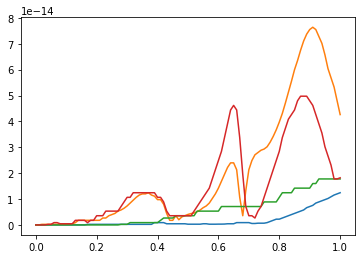

In [9]:
states_L = states_L.detach().numpy()
states_a = states_a.detach().numpy()

for err in np.abs(states_L - states_a).max(axis=1).reshape(101, 4).T:
    plt.plot(t, err);
    # plot legend


Seems like everything works as expected! Now we can generate the training and testing datasets (should run for ~2 minutes):

In [10]:
N = 150000

# Pick a single initial condition:
x0 = torch.tensor(
    [
        [[3 * np.pi / 7, 0],
         [3 * np.pi / 4, 0]]
    ],
)

# Advance in time for 150 seconds
t = torch.arange(2 * N) / 1000
states_a = torchdiffeq.odeint(
    partial(ode_analytical, **system_parameters),
    x0, t, atol=1e-8, rtol=1e-8
).detach().numpy()

x_train = states_a[:N].reshape(N, 2, 2)
x_test = states_a[N:].reshape(N, 2, 2)

# From each state, we'll evolve for 10 ms and set the result as the target for
# our predictions:
dt = 0.01
y_train = torchdiffeq.odeint(
    partial(ode_analytical, **system_parameters),
    torch.tensor(x_train),
    torch.tensor([0.0, dt]),
    method="rk4",
)[-1].detach().numpy()
y_test = torchdiffeq.odeint(
    partial(ode_analytical, **system_parameters),
    torch.tensor(x_test),
    torch.tensor([0.0, dt]),
    method="rk4",
)[-1].detach().numpy()

Here's a visualization of our dataset:

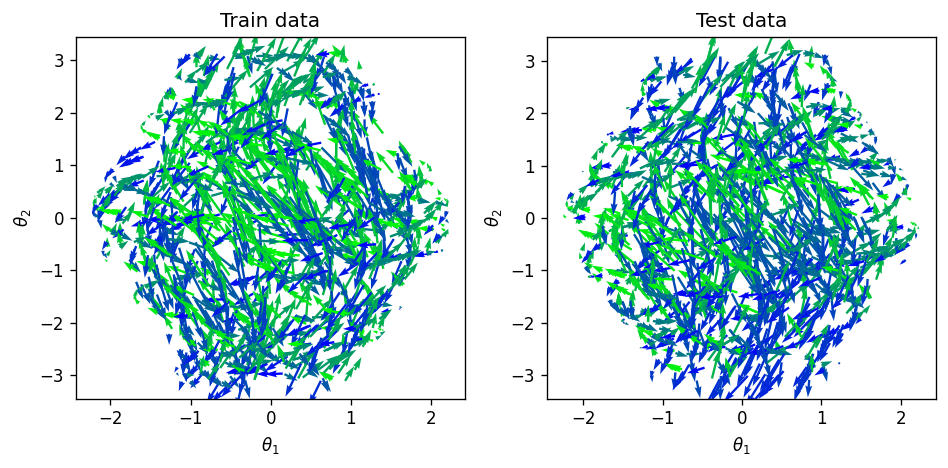

In [11]:
# This code is heavily borrowed from the original LNN tutorial, https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq
def plot_dynamics(x_train, x_test):
    x_train = x_train.transpose(0, 2, 1).reshape(-1, 4)
    x_test = x_test.transpose(0, 2, 1).reshape(-1, 4)

    def normalize_dp(state):
        # wrap generalized coordinates to [-pi, pi]
        return np.concatenate([(state[:,:2] + np.pi) % (2 * np.pi) - np.pi, state[:,2:]], axis=1)

    # preprocess
    train_vis = normalize_dp(x_train)
    test_vis = normalize_dp(x_test)

    vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
    vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
    train_colors = vel_color(vel_angle(train_vis))
    test_colors = vel_color(vel_angle(test_vis))

    # plot
    SCALE = 80 ; WIDTH = 0.006
    plt.figure(figsize=[8,4], dpi=120)
    plt.subplot(1,2,1)
    plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
    plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

    plt.subplot(1,2,2)
    plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
    plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

    plt.tight_layout() ; plt.show()

idx = np.random.choice(len(x_train), 1500)
plot_dynamics(x_train[idx], x_test[idx])

In [12]:
# Our data is a set of 2x2 tensors of the form:
# [[th1, w1],
#  [th2, w2]]

for i in [x_train, y_train, x_test, y_test]:
    print(i.shape)

(150000, 2, 2)
(150000, 2, 2)
(150000, 2, 2)
(150000, 2, 2)


## Task 1: learning a Lagrangian of a known form

Here, we define a pytorch lighting module that only has 5 parameters ($m_1$, $m_2$, $l_1$, $l_2$ and $g$) and whose forward call plugs them into the double pendulum `lagrangian` function that we defined in the very beginning of the notebook. We then learn these 5 parameters with gradient descent.

In [14]:

class DoublePendulumLagrangianModel(pl.LightningModule):
    def __init__(self, lr, lr_decay):
        super().__init__()
        self.save_hyperparameters() # This is pytorch_lightning's way of tracking
                                    # the hyperparameters (arguments of __init__).
                                    # After this call, `lr` and `lr_decay` are
                                    # accessible through `self.hparams.lr` and
                                    # `self.hparams.lr_decay`.

        # Let's define our learnable parameters:
        for param_name in ["m1", "m2", "l1", "l2", "g"]:
            self.register_parameter(
                name=f"param_{param_name}",
                param=torch.nn.Parameter(
                    torch.randn(()) + 5.0, # random initialization
                )
            )

        self.lr = self.hparams.lr
        self.lr_decay = self.hparams.lr_decay

    def forward(self, q, qt):
        # This method should call the analytical lagrangian with the trainable
        # parameters of our model plugged in.

        return lagrangian(
            q, qt,
            m1=self.param_m1,
            m2=self.param_m2,
            l1=self.param_l1,
            l2=self.param_l2,
            g=self.param_g,
        )

    # We'll use the same function to calculate the loss value at both training
    # and validation steps:
    def _shared_loss_calculation(self, batch):
        batch_x, batch_y = batch

        # Make a single step prediction using our model as the Lagrangian function
        pred_next_state = torchdiffeq.odeint(
            partial(
                ode_function,
                lagrangian=self,
                create_graph=self.training # this helps avoiding unnecessary
                                           # memory allocations during validation
            ),
            batch_x.clone().detach().requires_grad_(True), # initial conditions
            torch.tensor([0.0, dt]).to(self.device), # single time step
            method="rk4",
        )[-1] # taking the state at the last moment (dt)
        target_next_state = batch_y

        # MSE loss:
        return (
            ((pred_next_state - target_next_state) / dt)**2 # we divide the difference by `dt`
        ).mean()                                            # to get an estimate of the difference
                                                            # between the derivatives

    def training_step(self, batch, batch_idx):
        loss = self._shared_loss_calculation(batch)

        self.log("loss/train", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        assert not self.training
        torch.set_grad_enabled(True) # need gradient calculation enabled in the forward pass
        loss = self._shared_loss_calculation(batch)
        torch.set_grad_enabled(False)

        self.log("loss/test", loss)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": opt,
            "lr_scheduler": torch.optim.lr_scheduler.LambdaLR(
                opt, lambda epoch: self.lr_decay**epoch # will decay learning rate exponentially
            ),
        }

We can now create an instance of our model and a `Trainer` object for training:

In [22]:
device = "cuda"

model_lagrangian = DoublePendulumLagrangianModel(lr=1e-2, lr_decay=0.96)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(x_train),
        torch.tensor(y_train),
    ),
    batch_size=1500,
    shuffle=True,
    num_workers=1,
)

np.random.seed(42)
idx_test = np.random.choice(len(x_test), 1500)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(x_test[idx_test]),
        torch.tensor(y_test[idx_test]),
    ),
    batch_size=1500,
    num_workers=1,
)

trainer_lagrangian = pl.Trainer(
    gpus=1, max_epochs=15, log_every_n_steps=5,# flush_logs_every_n_steps=10,
    callbacks=pl.callbacks.LearningRateMonitor(logging_interval="epoch"),
    logger=pl.loggers.TensorBoardLogger(
        save_dir="./", name="lightning_logs/lagrangian"
    ),
)

/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
!rm -rf lightning_logs

Run tensorboard for monitoring:

In [24]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Launching TensorBoard...

Fit the model (keep an eye on the tensorboard window in the previous cell):

In [25]:
trainer_lagrangian.fit(model_lagrangian, train_loader, test_loader)

Missing logger folder: ./lightning_logs/lagrangian
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type | Params
------------------------------
------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [26]:
latest_lagrangian_loss = model_lagrangian.trainer.logged_metrics["loss/test"]

assert latest_lagrangian_loss <= 1e-6, f"Obtained loss ({latest_lagrangian_loss}) is too large."

print(f"Great! The loss is {latest_lagrangian_loss} <= 1e-6.")

Great! The loss is 2.668210227726217e-28 <= 1e-6.


## Task 2: review and explain the learned parameters

So, now that we've achieved a good value of the loss, let's look at the learned parameters and compare them with the ground truth:

In [27]:
learned_parameters = dict(
    m1=model_lagrangian.param_m1.detach().cpu().numpy(),
    m2=model_lagrangian.param_m2.detach().cpu().numpy(),
    l1=model_lagrangian.param_l1.detach().cpu().numpy(),
    l2=model_lagrangian.param_l2.detach().cpu().numpy(),
    g=model_lagrangian.param_g.detach().cpu().numpy(),
)

print("parameter | true value | learned value")
for par in ["m1", "m2", "l1", "l2", "g"]:
    print(f"  {par:2}      |   {system_parameters[par]:6.3f}   |   {learned_parameters[par]:6.3f}")

parameter | true value | learned value
  m1      |    1.000   |    4.412
  m2      |    1.000   |    4.412
  l1      |    1.000   |    1.182
  l2      |    1.000   |    1.182
  g       |    9.800   |   11.579


Hmmm... looks like the learned parameters are quite different from the ground truth! But the loss value is very small, i.e., we are predicting the trajectory correctly. Can you explain this?

**Explain, why the learned parameters are significantly different compared to the ground truth, yet the trajectories are predicted correctly.**

*Hint: look at the analytical Lagrangian and check, which transformations of it would lead to the same E-L equations. Which relations between parameters are important? Compare these relations for the ground truth and learned parameters.*

In [35]:
divisor_key = 'l2'
# if divisor_key in learned_parameters:
divisor = learned_parameters[divisor_key]
learned_parameters_reg = learned_parameters
for key in learned_parameters:
    # if key != divisor_key:
    #     learned_parameters[key] /= divisor
        learned_parameters_reg[key] /= divisor

print("parameter | true value | learned value")
for par in ["m1", "m2", "l1", "l2", "g"]:
    print(f"  {par:2}      |   {system_parameters[par]:6.3f}   |   {learned_parameters_reg[par]:6.3f}")
# else:
#     divisor = learned_parameters['l1']
# learned_parameters_reg = learned_parameters  learned_parameters['l1']

parameter | true value | learned value
  m1      |    1.000   |    2.675
  m2      |    1.000   |    3.160
  l1      |    1.000   |    0.846
  l2      |    1.000   |    1.000
  g       |    9.800   |   11.579


## Task 3: training an LNN

Now we'll assume we don't know the general form of the Lagrangian. So, we'll just model it with a fully connected neural network.

Note: experiments show that LNN training is not very stable. The speed of convergence may very much depend on random initializations. In the code below we implement a trick to make the convergence more stable: we first initialize a set of `n_nets` independent networks and pretrain them all for `pretrain_epochs` epochs. After that, we select the one that gives the best validation loss and continue training it, while forgetting about the others.

Since we're going to create a number of fully connected networks, it's reasonable to write a function that does it for us.

In [36]:
def build_mlp(n_in, width, depth, n_out, activation):
    """
    Creates a fully connected network (an instance of torch.nn.Sequential)

    Params:
      n_in - input size
      width - size of the hidden representations
      depth - number of hidden representations
      n_out - output size
      activation - function that creates an activation layer
    """

    # Notes:
    #  - `activation` is a function that doesn't take any arguments, i.e. 
    #    just a call like `activation()` returns you an activation layer
    #
    #  - The returned object should be an instance of torch.nn.Sequential
    #
    #  - `depth` is the number of hidden representations. So, e.g. `depth=1`
    #    means that there is 2 linear transformations (n_in -> width -> n_out)

    layers = [
        torch.nn.Linear(n_in, width), activation()
    ]
    for _ in range(depth - 1):
        layers.append(torch.nn.Linear(width, width))
        layers.append(activation())
    layers.append(torch.nn.Linear(width, n_out))
    return torch.nn.Sequential(*layers)


def _validate_impl(n_in, width, depth, n_out, activation):
    dummy_mlp = build_mlp(n_in, width, depth, n_out, activation)
    num_layers = 2 * depth + 1

    assert isinstance(dummy_mlp, torch.nn.Sequential), f"Expected a torch.nn.Sequential, got {dummy_mlp.__class__.__name__} instead."
    assert len(dummy_mlp) == num_layers, "Your MLP has incorrect number of layers"
    for i in range(0, num_layers, 2):
        assert isinstance(dummy_mlp[i], torch.nn.Linear), f"Layer {i} should be a torch.nn.Linear (got {dummy_mlp[i].__class__.__name__} instead)."
    for i in range(1, num_layers, 2):
        assert isinstance(dummy_mlp[i], activation), f"Layer {i} should be a {activation.__name__} (got {dummy_mlp[i].__class__.__name__} instead)."
    assert dummy_mlp[0].weight.shape == (width, n_in), f"Layer 0 should have {n_in} inputs and {width} outputs. Got {dummy_mlp[0].weight.shape[1]} inputs and {dummy_mlp[0].weight.shape[0]} outputs."
    for i in range(2, num_layers - 1, 2):
        assert dummy_mlp[i].weight.shape == (width, width), f"Layer {i} should have {width} inputs and {width} outputs. Got {dummy_mlp[i].weight.shape[1]} inputs and {dummy_mlp[i].weight.shape[0]} outputs."
    assert dummy_mlp[-1].weight.shape == (n_out, width), f"Last layer should have {width} inputs and {n_out} outputs. Got {dummy_mlp[-1].weight.shape[1]} inputs and {dummy_mlp[-1].weight.shape[0]} outputs."

_validate_impl(5, 7, 3, 3, torch.nn.ReLU)
_validate_impl(16, 128, 4, 10, torch.nn.Sigmoid)
print("All ok!")

All ok!


In [37]:
class LNN(pl.LightningModule):
    def __init__(self, lr, lr_decay, width, n_nets, pretrain_epochs, euler_epochs):
        super().__init__()
        self.save_hyperparameters()

        # `ModuleList` ensures that all the parameters of the children networks
        # are registered in the parent module. Each network will be of the same
        # architecture: two hidden layers with `width` neurons and `Softplus`
        # activations in between. Note that we can't use ReLU activations as
        # they will result in 0 second derivatives everywhere.
        self.networks = torch.nn.ModuleList(
            [build_mlp(6, width, 2, 1, torch.nn.Softplus) for _ in range(n_nets)]
        )

        self.lr = self.hparams.lr
        self.lr_decay = self.hparams.lr_decay
        self.n_nets = self.hparams.n_nets

        # After this many epochs we'll pick the best network and train only it:
        self.pretrain_epochs = self.hparams.pretrain_epochs

        # Using 4-th order Runge-Kutta (RK4) from the beginning may be unstable, since
        # it requires multiple evaluations of the function per step, where the
        # evaluation locations depend on the value of the function in the first
        # evaluation (which can, e.g., get too large). Therefore, we'll first
        # use Euler integration scheme and only switch to RK4 after this many
        # epochs:
        self.euler_epochs = self.hparams.euler_epochs

        self.pretraining = True
        self.method = "euler"

    def forward(self, q, qt, i=None):
        # We need to tell, which of the networks to use. If `i` is not provided,
        # pick the best one (which is decided at the end of pretraining).
        if i is None:
            i = self.best_id

        # Since our network is fully connected, we need to put our input into
        # a single vector. Note that `q` contains angles, which are periodic.
        # One of the simplest ways of incorporating this periodicity into the
        # architecture is by transforming `q` to `[sin(q), cos(q)]`:
        x = torch.stack([torch.sin(q), torch.cos(q), qt], axis=-1)
        return self.networks[i](x.reshape(x.shape[0], 6))

    def _shared_loss_calculation(self, batch):
        # This function is similar to the one in DoublePendulumLagrangianModel,
        # but there's a little twist: now the behavior depends on whether we are
        # in pretraining or training mode.
        
        # In the pretraining mode, we want to calculate losses for all
        # the networks, aggregate them to minimize them simultaneously, but then
        # also calculate the value and index of the smallest one - for monitoring
        # and selecting the best network after pretraining.

        # In the training mode, we only want to calculate the loss for the most
        # promissing network.

        batch_x, batch_y = batch

        pred_next_state = torch.stack([
            torchdiffeq.odeint(                                # This call is
                partial(                                       # same as in the
                    ode_function,                              # previous model
                    lagrangian=partial(self.forward, i=i),     # (with the only
                    create_graph=self.training                 # difference that
                ),                                             # now we need to
                batch_x.clone().detach().requires_grad_(True), # provide `i` to
                torch.tensor([0.0, dt]).to(self.device),       # the forward
                method=self.method,                            # call).
            )[-1] for i in (
                range(self.n_nets)       # either iterating over all the nets or
                if self.pretraining else # picking the best one, depending on
                [self.best_id]           # whether we're in the pretraining mode
            )
        ], axis=1) # <-- stack all the predictions into a single tensor
        # the resulting shape is (batch_size, n_nets, 2, 2)

        target_next_state = batch_y[:,None] # adding an axis to compare the
                                            # target with all the predictions at
                                            # the same time

        # Averaging MSE over all the axes but the one enumerating different networks:
        losses = (((pred_next_state - target_next_state) / dt)**2).mean(axis=(0, 2, 3))
        # Returning a tuple:
        return (
            losses.sum(), # aggregated loss to minimize
            losses.min(), # minimal loss (for monitoring during pretraining)
            torch.argmin(losses) # id of the best network (for picking after pretraining)
        )

    def training_step(self, batch, batch_idx):
        loss, best_loss, best_id = self._shared_loss_calculation(batch)

        self.log("loss/train", loss)
        self.log("best_loss/train", best_loss)
        self.log("best_id/train", best_id)
        return loss

    def validation_step(self, batch, batch_idx):
        assert not self.training
        torch.set_grad_enabled(True)
        loss, best_loss, best_id = self._shared_loss_calculation(batch)
        torch.set_grad_enabled(False)

        self.log("loss/test", loss)
        self.log("best_loss/test", best_loss)
        self.log("best_id/test", best_id)
        # Here we record the index of the last best network:
        self.last_best_id = best_id.detach().cpu().numpy()
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": opt,
            "lr_scheduler": torch.optim.lr_scheduler.LambdaLR(
                opt, lambda epoch: ( # decay the learning rate only after pretraining:
                    1.0
                    if epoch < self.pretrain_epochs else
                    self.lr_decay**(epoch - self.pretrain_epochs)
                )
            ),
        }

    def on_train_epoch_start(self):
        if self.trainer.current_epoch == self.pretrain_epochs:
            print(f"Finishing pretraining, picking id {self.last_best_id}")
            self.pretraining = False
            self.best_id = self.last_best_id
        if self.trainer.current_epoch == self.euler_epochs:
            print("Switching from Euler to RK4")
            self.method = "rk4"


We can now initialize and train an LNN model:

In [38]:
model_lnn = LNN(lr=1e-2, width=100, lr_decay=0.96, n_nets=32, pretrain_epochs=2, euler_epochs=20)

# 40 epochs should take ~10 minutes on Colab. If you have time, feel free to
# train for longer.
trainer_lnn = pl.Trainer(
    gpus=1, max_epochs=40, log_every_n_steps=5,# flush_logs_every_n_steps=10,
    callbacks=pl.callbacks.LearningRateMonitor(logging_interval="epoch"),
    logger=pl.loggers.TensorBoardLogger(
        save_dir="./", name="lightning_logs/lnn"
    ),
)

/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Run the training (you can use the same tensorboard window above for monitoring):

In [ ]:
trainer_lnn.fit(model_lnn, train_loader, test_loader)

Missing logger folder: ./lightning_logs/lnn
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name     | Type       | Params
----------------------------------------
0 | networks | ModuleList | 348 K 
----------------------------------------
348 K     Trainable params
0         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('best_id/test', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float64.
  warning_cache.warn(
/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the

Training: 0it [00:00, ?it/s]

/home/mbosetti/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('best_id/train', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float64.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Finishing pretraining, picking id 5


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Switching from Euler to RK4


Validation: 0it [00:00, ?it/s]

Now that the model is trained, let's pick 9 points from the test set and evolve the system for 10 seconds - based on the analytical solution and on our model. We will then compare the resulting trajectories:

In [ ]:
x0 = torch.tensor(x_test[np.random.choice(len(x_test), 9)], requires_grad=True)
t = torch.linspace(0, 10, 1001)

model_lnn.eval()
%time truth = torchdiffeq.odeint(partial(ode_analytical, **system_parameters), x0, t, method="rk4")
%time preds = torchdiffeq.odeint(partial(ode_function, lagrangian=model_lnn), x0, t, method="rk4")

truth = truth.detach().numpy()
preds = preds.detach().numpy()

In [ ]:
color_truth = "#1060a0"
color_pred = "#d08010"

plt.figure(figsize=(15, 9))
for i_tr in range(9):
    plt.subplot(3, 3, i_tr + 1)
    plt.plot(t, truth[:,i_tr,0,0], color=color_truth, label="theta_1, truth")
    plt.plot(t, preds[:,i_tr,0,0], color=color_pred, label="theta_1, prediction")
    plt.plot(t, truth[:,i_tr,1,0], "--", color=color_truth, label="theta_2, truth")
    plt.plot(t, preds[:,i_tr,1,0], "--", color=color_pred, label="theta_2, prediction")
    if i_tr == 0:
        plt.legend();
plt.tight_layout()

The code below renders the obtained trajectories as an animation (takes about 2 minutes to run):

In [ ]:
class PendulumVisualizer:
    def __init__(
        self,
        ax,
        trajectory,
        params,
        tail_len=100,
        bone_color="black",
        bead_color=color_truth,
        delta_z=0,
    ):
        self.trajectory = trajectory
        self.tail_len = tail_len
        self.params = params

        xx, yy = self.coords_at_step(0)
        self.line, = ax.plot(xx, yy, color=bone_color, zorder=delta_z)
        self.c1 = plt.Circle((xx[1], yy[1]), 0.1, color=bead_color, zorder=10 + delta_z)
        self.c2 = plt.Circle((xx[2], yy[2]), 0.1, color=bead_color, zorder=10 + delta_z)
        self.tail = [
            plt.Line2D([0.0, 0.0], [0.0, 0.0], zorder=delta_z - 10, color=bead_color, alpha=0.5)
            for _ in range(self.tail_len)
        ]
        ax.add_patch(self.c1)
        ax.add_patch(self.c2)
        for t in self.tail:
            ax.add_artist(t)

    def angles_to_coords(self, q):
        l1 = self.params["l1"]
        l2 = self.params["l2"]

        x1 = l1 * np.sin(q[...,0])
        y1 = -l1 * np.cos(q[...,0])
        x2 = x1 + l2 * np.sin(q[...,1])
        y2 = y1 - l2 * np.cos(q[...,1])

        return (np.zeros_like(x1), x1, x2), (np.zeros_like(y1), y1, y2)

    def coords_at_step(self, i):
        return self.angles_to_coords(self.trajectory[i])

    def animate(self, i):
        xx, yy = self.coords_at_step(i)
        self.line.set_data(xx, yy)
        self.c1.center = (xx[1], yy[1])
        self.c2.center = (xx[2], yy[2])
        for it in range(self.tail_len):
            if i - it - 1 < 0:
                self.tail[it].set_alpha(0)
            else:
                xx_prev = xx; yy_prev = yy
                xx, yy = self.coords_at_step(i - it - 1)
                self.tail[it].set_data([xx[2], xx_prev[2]], [yy[2], yy_prev[2]])
                self.tail[it].set_alpha(1.0 - it / self.tail_len)
        return [self.line, self.c1, self.c2] + self.tail

def make_animation(trajs_A, trajs_B, n_frames=None, interval=10, label_A="A", label_B="B", **kwargs):
    assert trajs_A.shape == trajs_B.shape

    if n_frames is None:
        n_frames = trajs_A.shape[1]
    n = np.ceil(trajs_A.shape[0]**0.5).astype(int)

    fig, axx = plt.subplots(n, n, figsize=(5, 5), dpi=100, squeeze=False)
    axx = axx.reshape(-1)
    pvs = []

    first = True
    for ax, tr_A, tr_B in zip(axx, trajs_A, trajs_B):
        plt.sca(ax)
        plt.xlim(-2.1, 2.1)
        plt.ylim(-2.1, 2.1)
        pvs.append(PendulumVisualizer(ax, tr_A, system_parameters, **kwargs))
        pvs.append(PendulumVisualizer(
            ax, tr_B, system_parameters, delta_z=30, bead_color=color_pred, **kwargs
        ))
        if first:
            plt.legend(
                [pvs[-2].c2, pvs[-1].c2],
                [label_A, label_B],
                prop={'size': 7},
            )
            first = False
    for ax in axx:
        plt.sca(ax)
        plt.axis("off")
    plt.tight_layout()

    def animate(i):
        objs = []
        for pv in pvs:
            objs += pv.animate(i)
        return objs

    ani = animation.FuncAnimation(
        fig, animate, frames=n_frames, interval=interval, blit=True
    )
    return fig, ani

_, ani = make_animation(
    truth[::4,...,0].transpose(1, 0, 2),
    preds[::4,...,0].transpose(1, 0, 2),
    interval=40, label_A="truth", label_B="prediction",
)
html5_video = ani.to_html5_video()

Watch the video:

In [ ]:
HTML(html5_video)